In [2]:
import pandas as pd
import numpy as np
import pathlib
import os
import sys
import glob
import tensorflow as tf
# from tensorflow.keras.applications.inception_v3 import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from IPython.display import Image, display
import cv2
import json
%matplotlib inline

In [3]:
print(tf.__version__)

2.0.0-alpha0


## Preprocess data

In [4]:
data_path = "../data"
data_p = pathlib.Path(data_path)

In [5]:
meta_table = pd.read_csv("../_filename_dict.csv")

In [6]:
# Filter is_readable_image == False
f_table = meta_table[(meta_table['is_readable_image']) & (meta_table['is_completed_image'])].copy()
# f_table = f_table[f_table['_format'] != ".gif"].copy()
f_table.reset_index(drop=True, inplace=True)
f_table.fillna("", inplace=True)

In [7]:
f_table['sample'].value_counts()


电池      100
皮鞋      100
油桶       99
糖果       99
书本       99
       ... 
餐巾纸      54
硬果壳      53
玉米衣      53
尼龙制品     47
家养植物      7
Name: sample, Length: 154, dtype: int64

In [8]:
f_table['level0'].value_counts()

湿垃圾     3703
可回收物    3629
有害垃圾    2806
干垃圾     2407
Name: level0, dtype: int64

In [9]:
f_table.head()

,_filename,_format,sample,spider_id,level0,level1,is_readable_image,is_completed_image
0,干垃圾_编织袋_36.jpeg,.jpeg,编织袋,36,干垃圾,,True,True
1,湿垃圾_食材废料_水产_91.jpg,.jpg,水产,91,湿垃圾,食材废料,True,True
2,湿垃圾_过期食品_肉干_7.jpg,.jpg,肉干,7,湿垃圾,过期食品,True,True
3,干垃圾_橡皮泥_20.jpg,.jpg,橡皮泥,20,干垃圾,,True,True
4,有害垃圾_废含汞温度计、废含汞血压计_水银体温计_84.jpg,.jpg,水银体温计,84,有害垃圾,废含汞温度计、废含汞血压计,True,True


In [10]:
# target_label = "sample"
target_label = "level0"
filenames = ['../data/' + fname for fname in f_table['_filename'].tolist()]
lv0_labels = f_table[target_label].tolist()

In [11]:
labelencoder = preprocessing.LabelEncoder()
lv0_labels_encoded = labelencoder.fit_transform(lv0_labels)

In [12]:
print(labelencoder.transform(['可回收物', "有害垃圾", "湿垃圾", "干垃圾"]))
print(len(labelencoder.classes_))
lv0_n_classes = len(labelencoder.classes_)
level0_label_dict = {k:v for k,v in enumerate(labelencoder.classes_)}

[0 2 3 1]
4


In [13]:
print(labelencoder.classes_)
print(level0_label_dict)

['可回收物' '干垃圾' '有害垃圾' '湿垃圾']
{0: '可回收物', 1: '干垃圾', 2: '有害垃圾', 3: '湿垃圾'}


In [14]:
raw_filenames, test_filenames, raw_labels, test_labels = train_test_split(filenames
                                                                        , lv0_labels_encoded
                                                                        , train_size=0.9
                                                                        , random_state=42)

train_filenames, val_filenames, train_labels, val_labels = train_test_split(raw_filenames
                                                                        , raw_labels
                                                                        , train_size=0.9
                                                                        , random_state=42)

In [15]:
print(len(train_filenames), len(train_labels))
print(len(val_filenames), len(val_labels))
print(len(test_filenames), len(test_labels))

10161 10161
1129 1129
1255 1255


In [16]:
basenetwork = "inception"
# basenetwork = "mobilenet"

In [19]:
# Inception V3 299
if basenetwork == "inception":
    IMAGE_SIZE = 299
elif basenetwork == "mobilenet":
    IMAGE_SIZE = 128
# Mobilenet use 128
# IMAGE_SIZE = 128
BATCH_SIZE = 32
print(IMAGE_SIZE, BATCH_SIZE)

299 32


In [20]:
train_data = tf.data.Dataset.from_tensor_slices(
  (tf.constant(train_filenames), tf.constant(train_labels))
)
val_data = tf.data.Dataset.from_tensor_slices(
  (tf.constant(val_filenames), tf.constant(val_labels))
)

In [21]:
def _parse_fn(filename, label):
    try:
        # read file as byte
        image_string = tf.io.read_file(filename)
        # decode as string 
        image_decoded = tf.image.decode_jpeg(image_string, channels=3)
        # image_decoded = tf.image.decode_gif(image_string)
        ## P.S tf.image.decode_image return shapeless tensor.
        # image_decoded = tf.image.decode_image(image_string)
        
        # resize to given image size
        image_resized = tf.image.resize(image_decoded, (IMAGE_SIZE, IMAGE_SIZE))
        # normailization
        image_normalized = (tf.cast(image_resized, tf.float32)/127.5) - 1
    
        return image_normalized, label
        """image_casted = tf.cast(image_decoded, tf.float32)
        image_resized = tf.image.resize(image_casted, (IMAGE_SIZE, IMAGE_SIZE))
        image_preproc = tf.keras.applications.inception_v3.preprocess_input(image_resized)
        
        return image_preproc, label"""
    
    except Exception as e:
        print(e)
        print(filename)

In [22]:
train_data = (train_data.map(_parse_fn)\
            # .shuffle(buffer_size=5000)\
            .batch(BATCH_SIZE)
             )

val_data = (val_data.map(_parse_fn)
           # .shuffle(buffer_size=5000)
           .batch(BATCH_SIZE)
           )

## Define the model

In [23]:
# Base model with InceptionV3
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

if basenetwork == "inception":
    base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')
elif basenetwork == "mobilenet":
    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')

base_model.trainable = False

In [24]:
# Trainable classification head
maxpool_layer = tf.keras.layers.GlobalMaxPooling2D()
avgpool_layer = tf.keras.layers.GlobalAveragePooling2D()
# dense_layer = tf.keras.layers.Dense(1024, activation='relu')
dropout_layer = tf.keras.layers.Dropout(0.5)
prediction_layer = tf.keras.layers.Dense(lv0_n_classes, activation='softmax')

learning_rate = 0.0001

model = tf.keras.Sequential([
    base_model
    # mobilenetV2
    , avgpool_layer
    # , maxpool_layer
    # , dense_layer
    # , dropout_layer
    , prediction_layer
])

# Now the optimizer is under tf.keras.
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=learning_rate)
    # optimizer=tf.keras.optimizers.SGD(lr=learning_rate, momentum=0.9)
    ## Onehot encoding use categorical_crossentropy
    # , loss='categorical_crossentropy'
    ## Integer encoding, use sparse_categorical_crossentropy
    , loss='sparse_categorical_crossentropy'
    , metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 21,810,980
Trainable params: 8,196
Non-trainable params: 21,802,784
_________________________________________________________________


## Train model

In [37]:
num_epochs = 30
steps_per_epoch = round(len(train_filenames))//BATCH_SIZE
val_steps = 20
count = 0

In [39]:
count += 1
history = model.fit(train_data.repeat(),
                    epochs=num_epochs,
                    steps_per_epoch = steps_per_epoch,
                    validation_data=val_data.repeat(), 
                    validation_steps=val_steps)

Epoch 1/30
317/317 [==============================] - 33s 105ms/step - loss: 0.7725 - accuracy: 0.6979 - val_loss: 1.1154 - val_accuracy: 0.6000
Epoch 2/30
317/317 [==============================] - 33s 104ms/step - loss: 0.7645 - accuracy: 0.7020 - val_loss: 1.1128 - val_accuracy: 0.6000
Epoch 3/30
317/317 [==============================] - 33s 104ms/step - loss: 0.7602 - accuracy: 0.7033 - val_loss: 1.1122 - val_accuracy: 0.6000
Epoch 4/30
317/317 [==============================] - 33s 103ms/step - loss: 0.7552 - accuracy: 0.7043 - val_loss: 1.1100 - val_accuracy: 0.5984
Epoch 5/30
317/317 [==============================] - 33s 103ms/step - loss: 0.7503 - accuracy: 0.7059 - val_loss: 1.1057 - val_accuracy: 0.6016
Epoch 6/30
317/317 [==============================] - 33s 104ms/step - loss: 0.7458 - accuracy: 0.7082 - val_loss: 1.1013 - val_accuracy: 0.6016
Epoch 7/30
317/317 [==============================] - 33s 104ms/step - loss: 0.7421 - accuracy: 0.7087 - val_loss: 1.0968 - val_ac

### Save the model

In [44]:
print(target_label, count * num_epochs)
save_name = "../models/_inceptV3_epoch_" + str(count * num_epochs) + "_without_dropout_" + target_label + ".h5"
# save_name = "../models/_mobilenet_epoch_" + str(count * num_epochs) + "_without_dropout_" + target_label + ".h5"

print(save_name)
print(os.path.basename(save_name))

level0 60
../models/_mobilenet_epoch_60_without_dropout_level0.h5
_mobilenet_epoch_60_without_dropout_level0.h5


In [42]:
# Save model weights
# model.save_weights('../models/weights_epoch_30_nodrop_out.h5')
model.save(save_name)

In [67]:
model_label_dict_conf = "../models/model_label_dict.conf"
if os.path.exists(model_label_dict_conf) and os.stat(model_label_dict_conf).st_size != 0:
    with open(model_label_dict_conf, 'r') as f:
        _save_params = json.loads(f.read())
        print(_save_params)
else:
    _save_params = {}

{'_mobilenet_epoch_60_without_dropout_level0': {'model_name': '_mobilenet_epoch_60_without_dropout_level0.h5', 'label_dict': {'0': '可回收物', '1': '干垃圾', '2': '有害垃圾', '3': '湿垃圾'}}}


In [68]:
if os.path.splitext(os.path.basename(save_name))[0] in _save_params.keys():
    _save_param = _save_params[os.path.splitext(os.path.basename(save_name))[0]]
else:
    _save_param = {}

_save_param['model_name'] = os.path.basename(save_name)
_save_param['label_dict'] = level0_label_dict
_save_param['IMAGE_SIZE'] = IMAGE_SIZE
_save_params[os.path.splitext(os.path.basename(save_name))[0]] = _save_param
with open("../models/model_label_dict.conf", "w") as f:
    _save_param_str = json.dumps(_save_params)
    f.write(_save_param_str)

### Take a look on Accuracy and Loss curve.

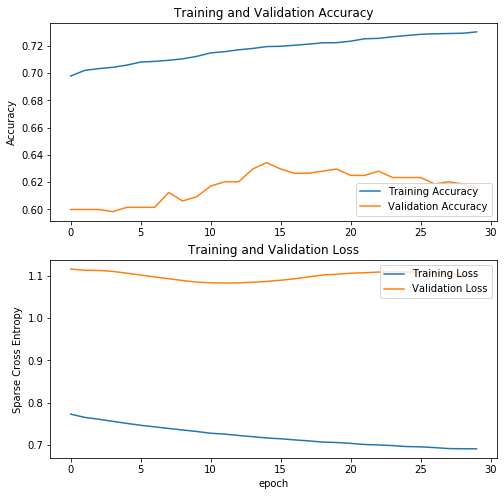

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Sparse Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [85]:
def _preprocess_imagefile(filename):
    try:
        # read file as byte
        image_string = tf.io.read_file(filename)
        # decode as string 
        image_decoded = tf.image.decode_jpeg(image_string, channels=3)
        # image_decoded = tf.image.decode_gif(image_string)
        ## P.S tf.image.decode_image return shapeless tensor.
        # image_decoded = tf.image.decode_image(image_string)
        
        # resize to given image size
        image_resized = tf.image.resize(image_decoded, (IMAGE_SIZE, IMAGE_SIZE))
        # normailization
        image_normalized = (tf.cast(image_resized, tf.float32)/127.5) - 1
    
        return image_normalized
        """image_casted = tf.cast(image_decoded, tf.float32)
        image_resized = tf.image.resize(image_casted, (IMAGE_SIZE, IMAGE_SIZE))
        image_preproc = tf.keras.applications.inception_v3.preprocess_input(image_resized)
        
        return image_preproc, label"""
    
    except Exception as e:
        print(e)
        print(filename)

### Input some test sample to test

In [99]:
random_filename = np.random.choice(test_filenames)
print(random_filename)
basename = random_filename.split("/")[-1].split(".")[0]
name_seg = basename.split("_")
sub_id = name_seg.pop()
sample = name_seg.pop()
labels = {"level"+str(i):l for i,l in enumerate(name_seg)}
print(labels['level0'])
random_x = _preprocess_imagefile(random_filename)
# print(random_x)
pred_y = model.predict(tf.expand_dims(random_x, axis=0))
print(pred_y)
print(labelencoder.classes_[pred_y.argmax()])

./data/湿垃圾_过期食品_糖果_37.jpg
湿垃圾
[[0.15937285 0.17156094 0.2781842  0.39088196]]
湿垃圾
